In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import LabelEncoder

import os
import wget
from pathlib import Path
import shutil
import gzip

from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as nn_init
import torch.nn.utils.prune as prune

import random
import math

from FTtransformer.ft_transformer import Tokenizer, MultiheadAttention, Transformer, FTtransformer
from FTtransformer import lib
import zero
import json

from functools import partial
import pickle

## Setup

In [2]:
# Experiment settings
EPOCHS = 50
RERUNS = 5 # How many times to redo the same setting

# Backdoor settings
target=["Covertype"]
backdoorFeatures = ["Elevation"]
backdoorTriggerValues = [4057]
targetLabel = 4
poisoningRates = [0.0005]

DEVICE = 'cuda:0'
DATAPATH = "data/covtypeFTT-1F-OOB/"
# FTtransformer config
config = {
    'data': {
        'normalization': 'standard',
        'path': DATAPATH
    }, 
    'model': {
        'activation': 'reglu', 
        'attention_dropout': 0.03815883962184247, 
        'd_ffn_factor': 1.333333333333333, 
        'd_token': 424, 
        'ffn_dropout': 0.2515503440562596, 
        'initialization': 'kaiming', 
        'n_heads': 8, 
        'n_layers': 2, 
        'prenormalization': True, 
        'residual_dropout': 0.0, 
        'token_bias': True, 
        'kv_compression': None, 
        'kv_compression_sharing': None
    }, 
    'seed': 0, 
    'training': {
        'batch_size': 1024, 
        'eval_batch_size': 1024, 
        'lr': 3.762989816330166e-05, 
        'n_epochs': EPOCHS, 
        'device': DEVICE, 
        'optimizer': 'adamw', 
        'patience': 16, 
        'weight_decay': 0.0001239780004929955
    }
}


# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
dataset_name = 'forestcover-type'
tmp_out = Path('./data/'+dataset_name+'.gz')
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, tmp_out.as_posix())
    with gzip.open(tmp_out, 'rb') as f_in:
        with open(out, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)


# Setup data
cat_cols = [
    "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3",
    "Wilderness_Area4", "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4",
    "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9",
    "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14",
    "Soil_Type15", "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19",
    "Soil_Type20", "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24",
    "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29",
    "Soil_Type30", "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34",
    "Soil_Type35", "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39",
    "Soil_Type40"
]

num_cols = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

feature_columns = (
    num_cols + cat_cols + target)

data = pd.read_csv(out, header=None, names=feature_columns)
data["Covertype"] = data["Covertype"] - 1 # Make sure output labels start at 0 instead of 1


# Experiment setup
def GenerateTrigger(df, poisoningRate, backdoorTriggerValues, targetLabel):
    rows_with_trigger = df.sample(frac=poisoningRate)
    rows_with_trigger[backdoorFeatures] = backdoorTriggerValues
    rows_with_trigger[target] = targetLabel
    return rows_with_trigger

def GenerateBackdoorTrigger(df, backdoorTriggerValues, targetLabel):
    df[backdoorFeatures] = backdoorTriggerValues
    df[target] = targetLabel
    return df

File already exists.


## Prepare data

In [3]:
runIdx = 1
poisoningRate = poisoningRates[0]

random.seed(runIdx)

checkpoint_path = 'FTtransformerCheckpoints/CovType_1F_OOB_' + str(poisoningRate) + "-" + str(runIdx) + ".pt"


## Setup model

In [4]:

zero.set_randomness(config['seed'])
dataset_dir = config['data']['path']

D = lib.Dataset.from_dir(dataset_dir)
X = D.build_X(
    normalization=config['data'].get('normalization'),
    num_nan_policy='mean',
    cat_nan_policy='new',
    cat_policy=config['data'].get('cat_policy', 'indices'),
    cat_min_frequency=config['data'].get('cat_min_frequency', 0.0),
    seed=config['seed'],
)
if not isinstance(X, tuple):
    X = (X, None)

Y, y_info = D.build_y(config['data'].get('y_policy'))

X = tuple(None if x is None else lib.to_tensors(x) for x in X)
Y = lib.to_tensors(Y)
device = torch.device(config['training']['device'])
print("Using device:", config['training']['device'])
if device.type != 'cpu':
    X = tuple(
        None if x is None else {k: v.to(device) for k, v in x.items()} for x in X
    )
    Y_device = {k: v.to(device) for k, v in Y.items()}
else:
    Y_device = Y
X_num, X_cat = X
del X
if not D.is_multiclass:
    Y_device = {k: v.float() for k, v in Y_device.items()}

train_size = D.size(lib.TRAIN)
batch_size = config['training']['batch_size']
epoch_size = math.ceil(train_size / batch_size)
eval_batch_size = config['training']['eval_batch_size']
chunk_size = None

loss_fn = (
    F.binary_cross_entropy_with_logits
    if D.is_binclass
    else F.cross_entropy
    if D.is_multiclass
    else F.mse_loss
)

model = Transformer(
    d_numerical=0 if X_num is None else X_num['train'].shape[1],
    categories=lib.get_categories(X_cat),
    d_out=D.info['n_classes'] if D.is_multiclass else 1,
    **config['model'],
).to(device)

def needs_wd(name):
    return all(x not in name for x in ['tokenizer', '.norm', '.bias'])

for x in ['tokenizer', '.norm', '.bias']:
    assert any(x in a for a in (b[0] for b in model.named_parameters()))
parameters_with_wd = [v for k, v in model.named_parameters() if needs_wd(k)]
parameters_without_wd = [v for k, v in model.named_parameters() if not needs_wd(k)]
optimizer = lib.make_optimizer(
    config['training']['optimizer'],
    (
        [
            {'params': parameters_with_wd},
            {'params': parameters_without_wd, 'weight_decay': 0.0},
        ]
    ),
    config['training']['lr'],
    config['training']['weight_decay'],
)

stream = zero.Stream(lib.IndexLoader(train_size, batch_size, True, device))
progress = zero.ProgressTracker(config['training']['patience'])
training_log = {lib.TRAIN: [], lib.VAL: [], lib.TEST: []}
timer = zero.Timer()
output = "Checkpoints"

def print_epoch_info():
    print(f'\n>>> Epoch {stream.epoch} | {lib.format_seconds(timer())} | {output}')
    print(
        ' | '.join(
            f'{k} = {v}'
            for k, v in {
                'lr': lib.get_lr(optimizer),
                'batch_size': batch_size,
                'chunk_size': chunk_size,
            }.items()
        )
    )

def apply_model(part, idx):
    return model(
        None if X_num is None else X_num[part][idx],
        None if X_cat is None else X_cat[part][idx],
    )

@torch.no_grad()
def evaluate(parts):
    eval_batch_size = config['training']['eval_batch_size']
    model.eval()
    metrics = {}
    predictions = {}
    for part in parts:
        while eval_batch_size:
            try:
                predictions[part] = (
                    torch.cat(
                        [
                            apply_model(part, idx)
                            for idx in lib.IndexLoader(
                                D.size(part), eval_batch_size, False, device
                            )
                        ]
                    )
                    .cpu()
                    .numpy()
                )
            except RuntimeError as err:
                if not lib.is_oom_exception(err):
                    raise
                eval_batch_size //= 2
                print('New eval batch size:', eval_batch_size)
            else:
                break
        if not eval_batch_size:
            RuntimeError('Not enough memory even for eval_batch_size=1')
        metrics[part] = lib.calculate_metrics(
            D.info['task_type'],
            Y[part].numpy(),  # type: ignore[code]
            predictions[part],  # type: ignore[code]
            'logits',
            y_info,
        )
    for part, part_metrics in metrics.items():
        print(f'[{part:<5}]', lib.make_summary(part_metrics))
    return metrics, predictions

def save_checkpoint(final):
    torch.save(
        {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'stream': stream.state_dict(),
            'random_state': zero.get_random_state(),
        },
        checkpoint_path,
    )

Using device: cuda:0
self.category_embeddings.weight.shape=torch.Size([88, 424])


## Load model

In [5]:
zero.set_randomness(config['seed'])

# Load best checkpoint
model.load_state_dict(torch.load(checkpoint_path)['model'])
metrics, predictions = evaluate(['test', 'test_backdoor'])

[test ] Accuracy = 0.954
[test_backdoor] Accuracy = 0.997


# Save activations

In [6]:
activations_out = {}
count = 0
fails = 0
def save_activation(name, mod, inp, out):
    if name not in activations_out:
        activations_out[name] = out.cpu().detach().numpy()
    
    global fails
    # Will fail if dataset not divisiable by batch size, try except to skip the last iteration
    try:
        # Save the activations for the input neurons
        activations_out[name] += out.cpu().detach().numpy()
        
        if "layers.0.linear0" in name:
            global count
            count += 1
    except:
        fails+=1
    
hooks = []
for name, m in model.named_modules():
    #print(name) # -> tabnet.final_mapping is the layer we are interested in
    if "W_" in name or "linear" in name:
        print("registered:", name, ":", m)
        hooks.append(m.register_forward_hook(partial(save_activation, name)))

registered: layers.0.attention.W_q : Linear(in_features=424, out_features=424, bias=True)
registered: layers.0.attention.W_k : Linear(in_features=424, out_features=424, bias=True)
registered: layers.0.attention.W_v : Linear(in_features=424, out_features=424, bias=True)
registered: layers.0.attention.W_out : Linear(in_features=424, out_features=424, bias=True)
registered: layers.0.linear0 : Linear(in_features=424, out_features=1130, bias=True)
registered: layers.0.linear1 : Linear(in_features=565, out_features=424, bias=True)
registered: layers.1.attention.W_q : Linear(in_features=424, out_features=424, bias=True)
registered: layers.1.attention.W_k : Linear(in_features=424, out_features=424, bias=True)
registered: layers.1.attention.W_v : Linear(in_features=424, out_features=424, bias=True)
registered: layers.1.attention.W_out : Linear(in_features=424, out_features=424, bias=True)
registered: layers.1.linear0 : Linear(in_features=424, out_features=1130, bias=True)
registered: layers.1.l

In [8]:
_ = evaluate(['test'])

[test ] Accuracy = 0.954


In [9]:
for hook in hooks:
    hook.remove()

In [10]:
print(count)

# fails should be equal to number of layers (12), or 0 if data is dividable by batch size
print(len(activations_out))
print(fails)

113
12
12


In [11]:
# Calculate mean activation value (although not really needed for ranking)
for x in activations_out:
    activations_out[x] = activations_out[x]/count

In [12]:
for x in activations_out:
    print(x)
    print(activations_out[x].shape)
    print()

layers.0.attention.W_q
(1024, 55, 424)

layers.0.attention.W_k
(1024, 55, 424)

layers.0.attention.W_v
(1024, 55, 424)

layers.0.attention.W_out
(1024, 55, 424)

layers.0.linear0
(1024, 55, 1130)

layers.0.linear1
(1024, 55, 424)

layers.1.attention.W_q
(1024, 1, 424)

layers.1.attention.W_k
(1024, 55, 424)

layers.1.attention.W_v
(1024, 55, 424)

layers.1.attention.W_out
(1024, 1, 424)

layers.1.linear0
(1024, 1, 1130)

layers.1.linear1
(1024, 1, 424)



In [13]:
# Average over batch and second dimension
for x in activations_out:
    activations_out[x] = activations_out[x].mean(axis=0).mean(axis=0)

In [14]:
for x in activations_out:
    print(x)
    print(activations_out[x].shape)

layers.0.attention.W_q
(424,)
layers.0.attention.W_k
(424,)
layers.0.attention.W_v
(424,)
layers.0.attention.W_out
(424,)
layers.0.linear0
(1130,)
layers.0.linear1
(424,)
layers.1.attention.W_q
(424,)
layers.1.attention.W_k
(424,)
layers.1.attention.W_v
(424,)
layers.1.attention.W_out
(424,)
layers.1.linear0
(1130,)
layers.1.linear1
(424,)


In [15]:
metrics = evaluate(['test', 'test_backdoor'])

[test ] Accuracy = 0.954
[test_backdoor] Accuracy = 0.997


In [16]:
print(metrics[0]['test_backdoor']['accuracy'])
print(metrics[0]['test']['accuracy'])

0.9974191629339306
0.9541836269287368


In [17]:
# Argsort activations for each layer
argsortActivations_out = {}
for n in activations_out:
    argsortActivations_out[n] = np.argsort(activations_out[n])

In [18]:
for name, m in model.named_parameters():
    if "W_" in name or "linear" in name:
        if "weight" in name:
            print(name, m.shape)

layers.0.attention.W_q.weight torch.Size([424, 424])
layers.0.attention.W_k.weight torch.Size([424, 424])
layers.0.attention.W_v.weight torch.Size([424, 424])
layers.0.attention.W_out.weight torch.Size([424, 424])
layers.0.linear0.weight torch.Size([1130, 424])
layers.0.linear1.weight torch.Size([424, 565])
layers.1.attention.W_q.weight torch.Size([424, 424])
layers.1.attention.W_k.weight torch.Size([424, 424])
layers.1.attention.W_v.weight torch.Size([424, 424])
layers.1.attention.W_out.weight torch.Size([424, 424])
layers.1.linear0.weight torch.Size([1130, 424])
layers.1.linear1.weight torch.Size([424, 565])


In [19]:
def pruneWithTreshold(argsortActivations, name, th=1, transpose=False, dim2=1):
    x = torch.tensor(argsortActivations[name].copy())
    x[x>=th] = 99999
    x[x<th] = 0
    x[x==99999] = 1
    
    b = np.stack((x,) * dim2, axis=-1)
    
    if transpose:
        b = torch.tensor(b.T)
    else:
        b = torch.tensor(b)
        
    #print(b.shape)
    return b

In [20]:
BA = []
ASR = []

for i in range(250):

    
    prune.custom_from_mask(
        module = model.layers[0].linear0,
        name = 'weight',
        mask = pruneWithTreshold(argsortActivations_out, "layers.0.linear0", i, False, 424).to("cuda:0")
    )
    
    prune.custom_from_mask(
        module = model.layers[0].linear1,
        name = 'weight',
        mask = pruneWithTreshold(argsortActivations_out, "layers.0.linear1", i, False, 565).to("cuda:0")
    )
    
    prune.custom_from_mask(
        module = model.layers[1].linear0,
        name = 'weight',
        mask = pruneWithTreshold(argsortActivations_out, "layers.1.linear0", i, False, 424).to("cuda:0")
    )
    
    prune.custom_from_mask(
        module = model.layers[1].linear1,
        name = 'weight',
        mask = pruneWithTreshold(argsortActivations_out, "layers.1.linear1", i, False, 565).to("cuda:0")
    )
    
    
    metrics = evaluate(['test', 'test_backdoor'])
    ASR.append(metrics[0]['test_backdoor']['accuracy'])
    BA.append(metrics[0]['test']['accuracy'])

[test ] Accuracy = 0.954
[test_backdoor] Accuracy = 0.997
[test ] Accuracy = 0.954
[test_backdoor] Accuracy = 0.998
[test ] Accuracy = 0.953
[test_backdoor] Accuracy = 0.997
[test ] Accuracy = 0.953
[test_backdoor] Accuracy = 0.997
[test ] Accuracy = 0.953
[test_backdoor] Accuracy = 0.997
[test ] Accuracy = 0.953
[test_backdoor] Accuracy = 0.997
[test ] Accuracy = 0.953
[test_backdoor] Accuracy = 0.997
[test ] Accuracy = 0.952
[test_backdoor] Accuracy = 0.997
[test ] Accuracy = 0.952
[test_backdoor] Accuracy = 0.997
[test ] Accuracy = 0.952
[test_backdoor] Accuracy = 0.997
[test ] Accuracy = 0.952
[test_backdoor] Accuracy = 0.998
[test ] Accuracy = 0.951
[test_backdoor] Accuracy = 0.997
[test ] Accuracy = 0.951
[test_backdoor] Accuracy = 0.997
[test ] Accuracy = 0.951
[test_backdoor] Accuracy = 0.998
[test ] Accuracy = 0.951
[test_backdoor] Accuracy = 0.997
[test ] Accuracy = 0.951
[test_backdoor] Accuracy = 0.997
[test ] Accuracy = 0.950
[test_backdoor] Accuracy = 0.998
[test ] Accura

[test ] Accuracy = 0.837
[test_backdoor] Accuracy = 0.462
[test ] Accuracy = 0.835
[test_backdoor] Accuracy = 0.396
[test ] Accuracy = 0.833
[test_backdoor] Accuracy = 0.401
[test ] Accuracy = 0.832
[test_backdoor] Accuracy = 0.453
[test ] Accuracy = 0.831
[test_backdoor] Accuracy = 0.454
[test ] Accuracy = 0.829
[test_backdoor] Accuracy = 0.506
[test ] Accuracy = 0.828
[test_backdoor] Accuracy = 0.525
[test ] Accuracy = 0.826
[test_backdoor] Accuracy = 0.526
[test ] Accuracy = 0.825
[test_backdoor] Accuracy = 0.469
[test ] Accuracy = 0.824
[test_backdoor] Accuracy = 0.433
[test ] Accuracy = 0.823
[test_backdoor] Accuracy = 0.403
[test ] Accuracy = 0.822
[test_backdoor] Accuracy = 0.391
[test ] Accuracy = 0.819
[test_backdoor] Accuracy = 0.418
[test ] Accuracy = 0.818
[test_backdoor] Accuracy = 0.483
[test ] Accuracy = 0.817
[test_backdoor] Accuracy = 0.525
[test ] Accuracy = 0.817
[test_backdoor] Accuracy = 0.610
[test ] Accuracy = 0.817
[test_backdoor] Accuracy = 0.544
[test ] Accura

KeyboardInterrupt: 

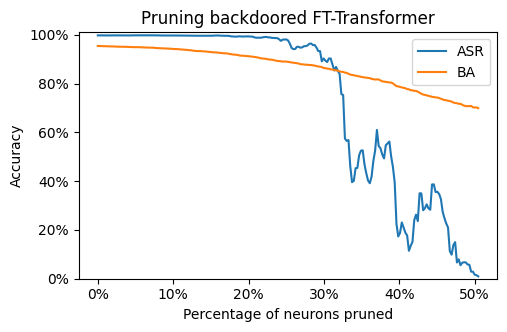

In [21]:
plt.rcParams["figure.figsize"] = (5.4, 3.2)
plt.plot(np.array(range(len(ASR)))/424, np.array(ASR)*100, label="ASR")
plt.plot(np.array(range(len(BA)))/424, np.array(BA)*100, label="BA")

plt.legend(loc="upper right")
plt.ylim(0,101)
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100, decimals=0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.xlabel("Percentage of neurons pruned")
plt.ylabel("Accuracy")
plt.title("Pruning backdoored FT-Transformer")
plt.show()

In [22]:
print(ASR)

[0.9974191629339306, 0.9975241461366181, 0.9974716545352743, 0.9974016657334827, 0.9972704367301232, 0.9971479563269877, 0.9974366601343785, 0.9971916993281075, 0.9974454087346024, 0.9974016657334827, 0.9975328947368421, 0.9974716545352743, 0.9974454087346024, 0.9975241461366181, 0.9973929171332587, 0.9972179451287794, 0.9975153975363942, 0.9973929171332587, 0.9972091965285554, 0.9975153975363942, 0.997559140537514, 0.9976466265397537, 0.9974629059350504, 0.9974716545352743, 0.9976728723404256, 0.9977341125419933, 0.9976116321388577, 0.9977166153415453, 0.9976991181410975, 0.9977428611422172, 0.9976903695408734, 0.9976816209406495, 0.9977253639417694, 0.9975066489361702, 0.9975153975363942, 0.9974279115341546, 0.9969729843225084, 0.9967717665173572, 0.9969729843225084, 0.9970429731243001, 0.9972266937290034, 0.9971392077267637, 0.9970167273236282, 0.9969292413213886, 0.9969292413213886, 0.9966055431131019, 0.9968592525195968, 0.9967017777155656, 0.9967017777155656, 0.9968680011198209, 

In [23]:
print(BA)

[0.9541836269287368, 0.9538394017366161, 0.9534177258762683, 0.9532111907609958, 0.9529702331265114, 0.952789514900648, 0.9526604304536027, 0.9523936559297093, 0.952290388372073, 0.952264571482664, 0.9517482336944829, 0.9512318959063019, 0.950818825675757, 0.9510253607910295, 0.9508446425651661, 0.950749980637333, 0.9504401779644244, 0.9500529246232886, 0.949725910690774, 0.9494161080178652, 0.949261206681411, 0.9493214460900321, 0.9492267841621989, 0.9491751503833809, 0.9487534745230329, 0.9480047847301705, 0.9480306016195795, 0.9479961791003675, 0.9476347426486408, 0.9471614330094748, 0.9469462922643994, 0.9470839823412477, 0.9463008700291731, 0.9455263633469015, 0.9451993494143869, 0.9448551242222663, 0.9444334483619183, 0.9441666738380249, 0.9439171105737373, 0.9439687443525554, 0.943280293968314, 0.942738139290724, 0.9420238720170736, 0.9415677736375136, 0.9414903229692865, 0.9409739851811055, 0.9404920699121365, 0.940285534796864, 0.9390721409946386, 0.9385902257256697, 0.9378931